# Notebook 5: Modelling

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from difflib import SequenceMatcher

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

DATA_PATH = os.path.join('..', 'data', 'processed', 'modelling')
PAIRS_PATH = os.path.join('..', 'data', 'processed', 'pairs')

## 1. Load Data

In [31]:
def load_data(name):
    return pd.read_csv(os.path.join(DATA_PATH, f'{name}.csv'))

print("Loading Datasets...")
X_train = load_data('X_train')
y_train = load_data('y_train').values.ravel() 

X_val = load_data('X_val')
y_val = load_data('y_val').values.ravel()

X_test = load_data('X_test')
y_test = load_data('y_test').values.ravel()

print(f"Training Shape:   {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")

Loading Datasets...
Training Shape:   (22444, 5)
Validation Shape: (2180, 5)


## 2. Training Models
### 2.1 Logistic Regression

In [32]:
print("--- Training Baseline: Logistic Regression ---")

lr_model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42))

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)
y_prob_lr = lr_model.predict_proba(X_val)[:, 1] 

print("Logistic Regression Results (Validation):")
print(classification_report(y_val, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob_lr):.4f}")

--- Training Baseline: Logistic Regression ---
Logistic Regression Results (Validation):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1807
           1       0.94      0.98      0.96       373

    accuracy                           0.99      2180
   macro avg       0.97      0.98      0.97      2180
weighted avg       0.99      0.99      0.99      2180

ROC-AUC Score: 0.9897


### 2.2 Random Forest

In [33]:
print("--- Training & Tuning: Random Forest ---")

param_grid = {
    'n_estimators': [100, 200],      # number of trees
    'max_depth': [5, 10, None],      # maximum depth 
    'min_samples_split': [2, 5]      # minimum samples to split a node
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, scoring='f1', 
                           n_jobs=-1, verbose=1
                           )

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"\nBest Parameters Found: {grid_search.best_params_}")

y_pred_rf = best_rf.predict(X_val)
y_prob_rf = best_rf.predict_proba(X_val)[:, 1]

print("\nRandom Forest Results (Validation):")
print(classification_report(y_val, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob_rf):.4f}")

--- Training & Tuning: Random Forest ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters Found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Results (Validation):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1807
           1       0.97      0.98      0.97       373

    accuracy                           0.99      2180
   macro avg       0.98      0.99      0.98      2180
weighted avg       0.99      0.99      0.99      2180

ROC-AUC Score: 0.9896


### 2.3 Model Comparison


Logistic Regression AUC: 0.9897
Random Forest AUC:       0.9896

>> Selected Best Model: Logistic Regression


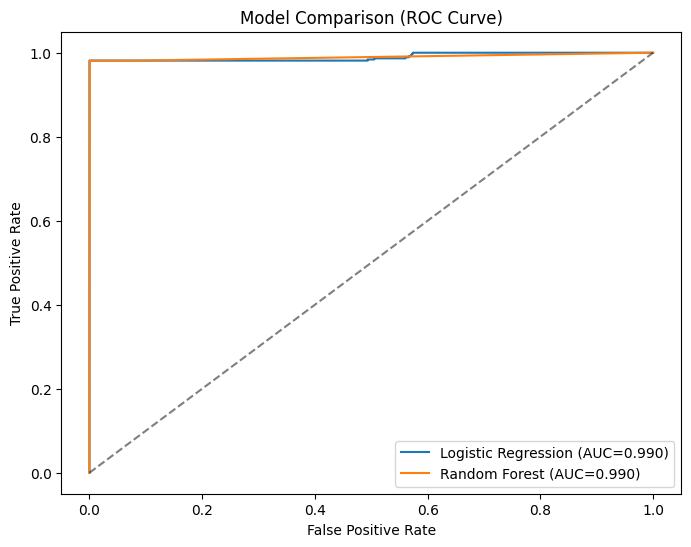

Confusion Matrix (Logistic Regression):


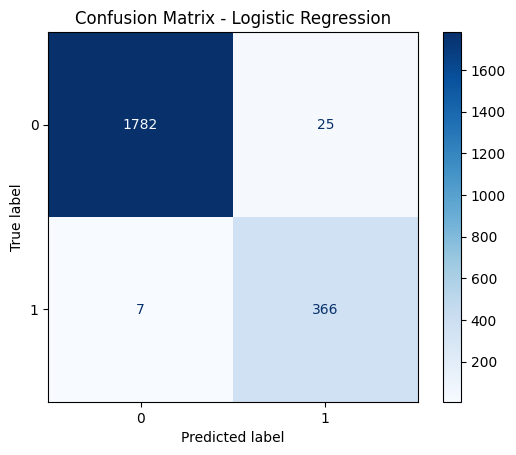

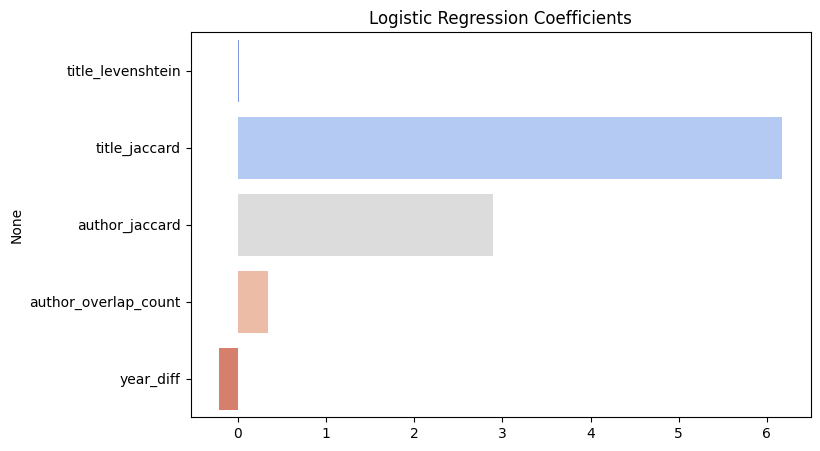

In [34]:
auc_lr = roc_auc_score(y_val, y_prob_lr)
auc_rf = roc_auc_score(y_val, y_prob_rf)

print(f"\nLogistic Regression AUC: {auc_lr:.4f}")
print(f"Random Forest AUC:       {auc_rf:.4f}")

if auc_rf >= auc_lr:
    best_model = best_rf
    best_model_name = "Random Forest"
    best_y_pred = y_pred_rf
    best_y_prob = y_prob_rf
else:
    best_model = lr_model
    best_model_name = "Logistic Regression"
    best_y_pred = y_pred_lr
    best_y_prob = y_prob_lr

print(f"\n>> Selected Best Model: {best_model_name}")

fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison (ROC Curve)')
plt.legend()
plt.show()

print(f"Confusion Matrix ({best_model_name}):")
ConfusionMatrixDisplay.from_predictions(y_val, best_y_pred, cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

if best_model_name == "Random Forest":
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances, y=feature_names, palette='viridis', hue = feature_names, legend=False)
    plt.title("Random Forest Feature Importance")
    plt.show()
elif best_model_name == "Logistic Regression":
    coeffs = best_model.named_steps['logisticregression'].coef_[0]
    feature_names = X_train.columns
    plt.figure(figsize=(8, 5))
    sns.barplot(x=coeffs, y=feature_names, palette='coolwarm', hue = feature_names, legend=False)
    plt.title("Logistic Regression Coefficients")
    plt.show()

## 3. Final Test and Evaluation
### 3.1 Final Test

--- Final Evaluation on Test Set (Logistic Regression) ---
Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4744
           1       0.96      1.00      0.98       950

    accuracy                           0.99      5694
   macro avg       0.98      1.00      0.99      5694
weighted avg       0.99      0.99      0.99      5694

Test ROC-AUC: 1.0000
Confusion Matrix (Logistic Regression on Test Set):


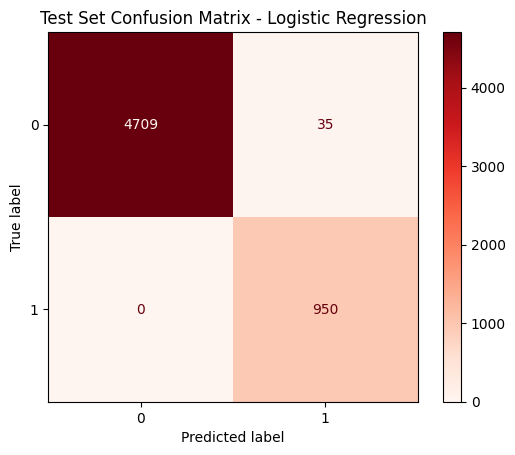

In [35]:
print(f"--- Final Evaluation on Test Set ({best_model_name}) ---")

y_pred_test = best_model.predict(X_test)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_test))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_test):.4f}")

print(f"Confusion Matrix ({best_model_name} on Test Set):")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Reds')
plt.title(f"Test Set Confusion Matrix - {best_model_name}")
plt.show()

### 3.2 Evaluation

In [ ]:
with open(os.path.join(PAIRS_PATH, 'manual_pairs.json'), 'r', encoding='utf-8') as f:
    manual_data = json.load(f)

def calculate_features_for_mrr(pairs):
    feats = []
    for p in pairs:
        src = p['source']
        cand = p['candidate']
        
        # 1. Title Features
        t1, t2 = src.get('clean_title', ''), cand.get('clean_title', '')
        lev = SequenceMatcher(None, t1, t2).ratio()
        
        t1_tok, t2_tok = set(t1.split()), set(t2.split())
        jac = len(t1_tok & t2_tok) / len(t1_tok | t2_tok) if (t1_tok | t2_tok) else 0.0
        
        # 2. Author Features (Handle sets loaded as lists)
        a1 = set(src.get('clean_author_tokens', []))
        a2 = set(cand.get('clean_author_tokens', []))
        auth_jac = len(a1 & a2) / len(a1 | a2) if (a1 | a2) else 0.0
        auth_ov = len(a1 & a2)
        
        try:
            y1_str, y2_str = str(src.get('year', 0)), str(cand.get('year', 0))
            y1 = int(y1_str) if y1_str.isdigit() else 0
            y2 = int(y2_str) if y2_str.isdigit() else 0
            
            ydiff = min(abs(y1 - y2), 50)
        except:
            ydiff = 10
            
        feats.append([lev, jac, auth_jac, auth_ov, ydiff])
    
    return pd.DataFrame(feats, columns=X_train.columns)

In [ ]:
print(f"Evaluating on {len(manual_data)} Manual Papers...")

global_reciprocal_ranks = []

for paper_id, test_pairs in manual_data.items():
    print(f"\n" + "="*60)
    print(f"Processing Paper: {paper_id} ({len(test_pairs)} pairs)")
    print("="*60)
    
    grouped_by_source = {}
    for p in test_pairs:
        src_id = p['source']['id']
        if src_id not in grouped_by_source:
            grouped_by_source[src_id] = []
        grouped_by_source[src_id].append(p)
    
    paper_rrs = []
    
    for idx, (src_id, candidates) in enumerate(grouped_by_source.items()):
        features_df = calculate_features_for_mrr(candidates)
        probs = best_model.predict_proba(features_df)[:, 1]
        
        ranked_candidates = []
        for i, pair in enumerate(candidates):
            ranked_candidates.append({
                'prob': probs[i],
                'label': pair['label'], 
                'cand_id': pair['candidate']['id'],
                'cand_title': pair['candidate']['clean_title'][:50] + "..."
            })
        
        ranked_candidates.sort(key=lambda x: x['prob'], reverse=True)
        
        # calculate MRR
        rr = 0
        found_rank = None
        for rank, item in enumerate(ranked_candidates[:5], start=1):
            if item['label'] == 1:
                rr = 1 / rank
                found_rank = rank
                break
        
        paper_rrs.append(rr)
        global_reciprocal_ranks.append(rr)

        if idx < 3:
            src_title = candidates[0]['source']['clean_title'][:60] + "..."
            print(f"\nSource [{src_id}]: {src_title}")
            print(f"  Ground Truth Found at Rank: {found_rank if found_rank else 'Not in Top 5'}")
            print(f"  Top 5 Candidates:")
            
            for rank, item in enumerate(ranked_candidates[:5], 1):
                mark = " [CORRECT MATCH]" if item['label'] == 1 else ""
                print(f"    {rank}. {item['cand_id']} | Prob: {item['prob']:.4f} | {item['cand_title']}{mark}")

    if paper_rrs:
        paper_mrr = sum(paper_rrs) / len(paper_rrs)
        print("-" * 40)
        print(f"-> Paper MRR: {paper_mrr:.4f}")

print("\n" + "="*40)
if global_reciprocal_ranks:
    total_mrr = sum(global_reciprocal_ranks) / len(global_reciprocal_ranks)
    print(f"GLOBAL MEAN RECIPROCAL RANK (MRR): {total_mrr:.4f}")
    print(f"Total Citations Evaluated: {len(global_reciprocal_ranks)}")
else:
    print("No manual pairs found.")
print("="*40)

Evaluating on 5 Manual Papers...

Processing Paper: 2211.03016 (54 pairs)

Source [dama]: dark matter dama libra its perspectives...
  Ground Truth Found at Rank: 1
  Top 5 Candidates:
    1. 2110.04734 | Prob: 0.9999 | dark matter dama libra its perspectives... [CORRECT MATCH]
    2. 0804.2738 | Prob: 0.0259 | dama libra apparatus...
    3. 2209.14898 | Prob: 0.0004 | cosmogenic activation sodium iodide...
    4. 2103.01175 | Prob: 0.0002 | annual modulation results three year exposure anai...
    5. 2205.13849 | Prob: 0.0002 | simulation background characterisation sabre south...

Source [cosine]: three year annual modulation search cosine 100...
  Ground Truth Found at Rank: 1
  Top 5 Candidates:
    1. 2111.08863 | Prob: 0.9946 | new results three year annual modulation search co... [CORRECT MATCH]
    2. 1903.10098 | Prob: 0.1239 | search dark matter induced annual modulation signa...
    3. 2107.07674 | Prob: 0.0009 | influence nai background mass testing dama modulat...
    4. 1